In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

# EDA + Preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Heart+Disease
heart_disease_df = pd.read_csv('Data/heart.csv')

def convClass(classType):
    if classType == 0:
        return -1
    else:
        return 1

heart_disease_df['target'] = heart_disease_df['target'].apply(convClass).astype('int32')
heart_disease_df['target'].value_counts()

 1    165
-1    138
Name: target, dtype: int64

In [3]:
heart_disease_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
print("Shape of Heart Disease dataset: ", heart_disease_df.shape)

Shape of Heart Disease dataset:  (303, 14)


### Data Preprocessing

In [5]:
print("Any null values for heart disease set: ", heart_disease_df.isnull().values.any())

Any null values for heart disease set:  False


In [6]:
print(heart_disease_df.head())
print("----")
print('Columns: \n', heart_disease_df.columns.values)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
----
Columns: 
 ['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'target']


### Split into training partitions + shuffling 3 sets (3 partition: 20/80, 50/50, 80/20; 3 shuffles)

In [7]:
train_partition_80_20 = []
test_partition_80_20 = []
train_partition_20_80 = []
test_partition_20_80 = []
train_partition_50_50 = []
test_partition_50_50 = []

heart_disease_y = heart_disease_df['target'].values
heart_disease_y = heart_disease_y.reshape(len(heart_disease_y), 1)
herat_disease_X_df = heart_disease_df.drop("target", axis=1)
heart_disease_X = herat_disease_X_df.values
X_and_Y = np.hstack((heart_disease_X, heart_disease_y))

for val in range(3):
    # Different trials (Shuffles)
    cur_X_and_Y = shuffle(X_and_Y)
    
    X_train_80_20, X_test_80_20, y_train_80_20, y_test_80_20 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.2)

    X_train_50_50, X_test_50_50, y_train_50_50, y_test_50_50 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.5)

    X_train_20_80, X_test_20_80, y_train_20_80, y_test_20_80 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.8)
    
    train_partition_80_20.append([X_train_80_20, y_train_80_20])
    test_partition_80_20.append([X_test_80_20, y_test_80_20])
    train_partition_20_80.append([X_train_20_80,y_train_20_80])
    test_partition_20_80.append([X_test_20_80,y_test_20_80])
    train_partition_50_50.append([X_train_50_50,y_train_50_50])
    test_partition_50_50.append([X_test_50_50,y_test_50_50])

In [8]:
# Confirm the partitions are correct
print("Shape of training samples 80_20: ", len(train_partition_80_20))
print("Size of training samples 80_20: ", len(train_partition_80_20[0][0]))
print("Size of training labels 80_20: ", len(train_partition_80_20[0][1]))
print("------------------------------------")
print("Shape of training samples 20_80: ", len(train_partition_20_80))
print("Size of training samples 20_80: ", len(train_partition_20_80[0][0]))
print("Size of training labels 20_80: ", len(train_partition_20_80[0][1]))
print("------------------------------------")
print("Shape of training samples 50_50: ", len(train_partition_50_50))
print("Size of training samples 50_50: ", len(train_partition_50_50[0][0]))
print("Size of training labels 50_50: ", len(train_partition_50_50[0][1]))
print("------------------------------------")

Shape of training samples 80_20:  3
Size of training samples 80_20:  242
Size of training labels 80_20:  242
------------------------------------
Shape of training samples 20_80:  3
Size of training samples 20_80:  60
Size of training labels 20_80:  60
------------------------------------
Shape of training samples 50_50:  3
Size of training samples 50_50:  151
Size of training labels 50_50:  151
------------------------------------


In [9]:
# Helper method to calculate accuracy
def calc_acc(X, Y, classifier):
    Y_pred = classifier.predict(X)
    return accuracy_score(Y, Y_pred)

## SVC

In [10]:
# Training errors
svc_training_errors_20_80 = []
svc_training_errors_80_20 = []
svc_training_errors_50_50 = []

svc_cv_errors_20_80 = []
svc_cv_errors_80_20 = []
svc_cv_errors_50_50 = []

svc_testing_errors_20_80 = []
svc_testing_errors_80_20 = []
svc_testing_errors_50_50 = []

svc_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
svc_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(svc_train_partitions):
    for ind in range(3):
        
        classifier = svm.SVC(kernel='linear')
        c_list = [1, 10, 100, 1000, 10000]
        svm_param_list = {'C': c_list}
        svc_grid_search = GridSearchCV(classifier, svm_param_list, cv=5, return_train_score=True)
        svc_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = svc_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = svc_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(svc_test_partitions[val][ind][0],
                               svc_test_partitions[val][ind][1], svc_grid_search)
        if val == 0:
            svc_training_errors_20_80.append(train_errors)
            svc_cv_errors_20_80.append(cross_val_errors)
            svc_testing_errors_20_80.append(test_errors)
        elif val == 1:
            svc_training_errors_80_20.append(train_errors)
            svc_cv_errors_80_20.append(cross_val_errors)
            svc_testing_errors_80_20.append(test_errors)
        elif val == 2:
            svc_training_errors_50_50.append(train_errors)
            svc_cv_errors_50_50.append(cross_val_errors)
            svc_testing_errors_50_50.append(test_errors)

In [11]:
# Show the accuracy of the 20-80 partition
print(svc_training_errors_20_80[0])
print(svc_training_errors_20_80[1])
print(svc_training_errors_20_80[2])

svc_avg_train_20_80 = np.mean(svc_training_errors_20_80, axis=0)
svc_avg_train_80_20 = np.mean(svc_training_errors_80_20, axis=0)
svc_avg_train_50_50 = np.mean(svc_training_errors_50_50, axis=0)

svc_avg_cv_20_80 = np.mean(svc_cv_errors_20_80, axis=0)
svc_avg_cv_80_20 = np.mean(svc_cv_errors_80_20, axis=0)
svc_avg_cv_50_50 = np.mean(svc_cv_errors_50_50, axis=0)

svc_avg_test_20_80 = np.mean(svc_testing_errors_20_80, axis=0)
svc_avg_test_80_20 = np.mean(svc_testing_errors_80_20, axis=0)
svc_avg_test_50_50 = np.mean(svc_testing_errors_50_50, axis=0)

[[0.925     ]
 [0.95416667]
 [0.975     ]
 [0.9375    ]
 [0.93333333]]
[[0.93333333]
 [0.96666667]
 [0.9875    ]
 [0.98333333]
 [0.975     ]]
[[0.97083333]
 [0.99583333]
 [1.        ]
 [1.        ]
 [1.        ]]


In [12]:
def heatmap_SVM(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'SVM Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


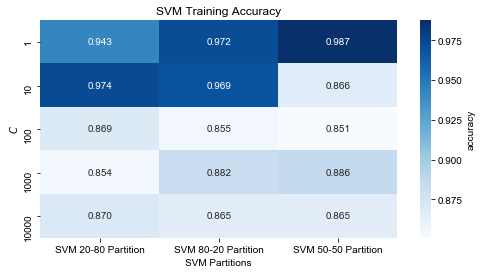

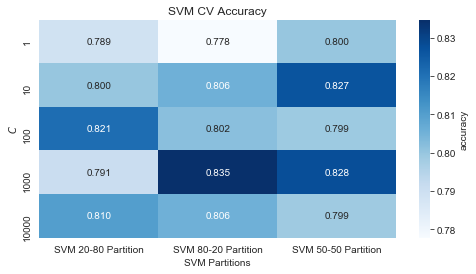

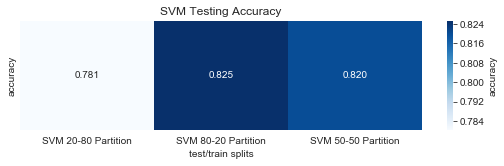

In [13]:
c_list = [1, 10, 100, 1000, 10000]
partition_names = ["SVM 20-80 Partition", "SVM 80-20 Partition", "SVM 50-50 Partition"]

svc_overall_train_acc = np.array([svc_avg_train_20_80, svc_avg_train_80_20, svc_avg_train_50_50])
svc_overall_train_acc = svc_overall_train_acc.reshape(5, 3)

svc_overall_cv_acc = np.array([svc_avg_cv_20_80, svc_avg_cv_80_20, svc_avg_cv_50_50])
svc_overall_cv_acc = svc_overall_cv_acc.reshape(5, 3)

svc_overall_test_acc = np.array([svc_avg_test_20_80, svc_avg_test_80_20, svc_avg_test_50_50]).reshape(1,3)

heatmap_SVM(svc_overall_train_acc, "SVM Training Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_cv_acc, "SVM CV Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_test_acc, "SVM Testing Accuracy", None, partition_names)

## KNN

In [14]:
# Training errors
knn_training_errors_20_80 = []
knn_training_errors_80_20 = []
knn_training_errors_50_50 = []

knn_cv_errors_20_80 = []
knn_cv_errors_80_20 = []
knn_cv_errors_50_50 = []

knn_testing_errors_20_80 = []
knn_testing_errors_80_20 = []
knn_testing_errors_50_50 = []

knn_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
knn_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(knn_train_partitions):
    for ind in range(3):
        # KNN Model
        neighbors_estimator = neighbors.KNeighborsClassifier()

        k_list = [1, 2, 3, 4, 5]
        param_grid = {'n_neighbors': k_list}
        neighbors_grid_search = GridSearchCV(neighbors_estimator, param_grid, cv=5, return_train_score=True)

        # 3. Use the grid searcher to fit the training set.
        neighbors_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = neighbors_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = neighbors_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(knn_test_partitions[val][ind][0],
                               knn_test_partitions[val][ind][1], neighbors_grid_search)
        if val == 0:
            knn_training_errors_20_80.append(train_errors)
            knn_cv_errors_20_80.append(cross_val_errors)
            knn_testing_errors_20_80.append(test_errors)
        elif val == 1:
            knn_training_errors_80_20.append(train_errors)
            knn_cv_errors_80_20.append(cross_val_errors)
            knn_testing_errors_80_20.append(test_errors)
        elif val == 2:
            knn_training_errors_50_50.append(train_errors)
            knn_cv_errors_50_50.append(cross_val_errors)
            knn_testing_errors_50_50.append(test_errors)

In [15]:
# Show the accuracy of the 20-80 partition
print(knn_training_errors_20_80[0])
print(knn_training_errors_20_80[1])
print(knn_training_errors_20_80[2])

knn_avg_train_20_80 = np.mean(knn_training_errors_20_80, axis=0)
knn_avg_train_80_20 = np.mean(knn_training_errors_80_20, axis=0)
knn_avg_train_50_50 = np.mean(knn_training_errors_50_50, axis=0)

knn_avg_cv_20_80 = np.mean(knn_cv_errors_20_80, axis=0)
knn_avg_cv_80_20 = np.mean(knn_cv_errors_80_20, axis=0)
knn_avg_cv_50_50 = np.mean(knn_cv_errors_50_50, axis=0)

knn_avg_test_20_80 = np.mean(knn_testing_errors_20_80, axis=0)
knn_avg_test_80_20 = np.mean(knn_testing_errors_80_20, axis=0)
knn_avg_test_50_50 = np.mean(knn_testing_errors_50_50, axis=0)

[[1.        ]
 [0.78333333]
 [0.82916667]
 [0.78333333]
 [0.7875    ]]
[[1.        ]
 [0.77083333]
 [0.8       ]
 [0.75833333]
 [0.7625    ]]
[[1.        ]
 [0.80416667]
 [0.82083333]
 [0.76666667]
 [0.75416667]]


In [16]:
def heatmap_KNN(acc_arr, title, k_list, split):
    if not k_list:
        plt.figure(figsize = (9,4))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'KNN Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

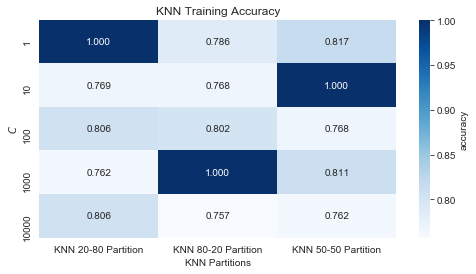

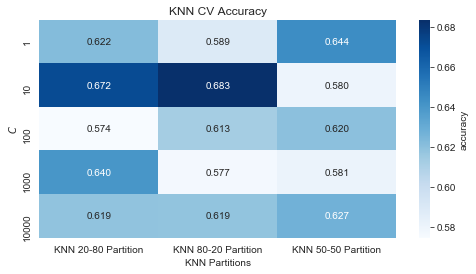

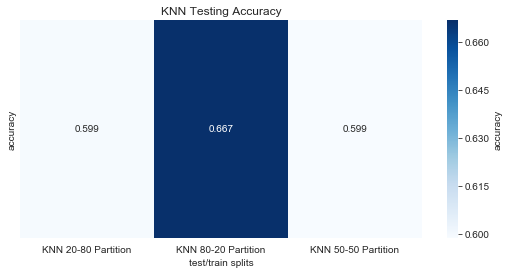

In [17]:
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
partition_names = ["KNN 20-80 Partition", "KNN 80-20 Partition", "KNN 50-50 Partition"]

knn_overall_train_acc = np.array([knn_avg_train_20_80, knn_avg_train_80_20, knn_avg_train_50_50])
knn_overall_train_acc = knn_overall_train_acc.reshape(5, 3)

knn_overall_cv_acc = np.array([knn_avg_cv_20_80, knn_avg_cv_80_20, knn_avg_cv_50_50])
knn_overall_cv_acc = knn_overall_cv_acc.reshape(5, 3)

knn_overall_test_acc = np.array([knn_avg_test_20_80,
                                 knn_avg_test_80_20, knn_avg_test_50_50]).reshape(1,3)

heatmap_KNN(knn_overall_train_acc, "KNN Training Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_cv_acc, "KNN CV Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_test_acc, "KNN Testing Accuracy", None, partition_names)

## Logistic Regression

In [18]:
# Training errors
lr_training_errors_20_80 = []
lr_training_errors_80_20 = []
lr_training_errors_50_50 = []

lr_cv_errors_20_80 = []
lr_cv_errors_80_20 = []
lr_cv_errors_50_50 = []

lr_testing_errors_20_80 = []
lr_testing_errors_80_20 = []
lr_testing_errors_50_50 = []

lr_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
lr_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(lr_train_partitions):
    for ind in range(3):

        log_reg_estimator  = LogisticRegression(solver='liblinear', multi_class='ovr')
        c_list = [0.001, 0.01, 0.1, 1, 10]

        log_param_list = {'C': c_list}

        log_grid_search = GridSearchCV(log_reg_estimator, log_param_list, cv=5, return_train_score=True)
        log_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = log_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = log_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(lr_test_partitions[val][ind][0],
                               lr_test_partitions[val][ind][1], log_grid_search)
        if val == 0:
            lr_training_errors_20_80.append(train_errors)
            lr_cv_errors_20_80.append(cross_val_errors)
            lr_testing_errors_20_80.append(test_errors)
        elif val == 1:
            lr_training_errors_80_20.append(train_errors)
            lr_cv_errors_80_20.append(cross_val_errors)
            lr_testing_errors_80_20.append(test_errors)
        elif val == 2:
            lr_training_errors_50_50.append(train_errors)
            lr_cv_errors_50_50.append(cross_val_errors)
            lr_testing_errors_50_50.append(test_errors)

In [19]:
# Show the accuracy of the 20-80 partition
print(lr_training_errors_20_80[0])
print(lr_training_errors_20_80[1])
print(lr_training_errors_20_80[2])

lr_avg_train_20_80 = np.mean(lr_training_errors_20_80, axis=0)
lr_avg_train_80_20 = np.mean(lr_training_errors_80_20, axis=0)
lr_avg_train_50_50 = np.mean(lr_training_errors_50_50, axis=0)

lr_avg_cv_20_80 = np.mean(lr_cv_errors_20_80, axis=0)
lr_avg_cv_80_20 = np.mean(lr_cv_errors_80_20, axis=0)
lr_avg_cv_50_50 = np.mean(lr_cv_errors_50_50, axis=0)

lr_avg_test_20_80 = np.mean(lr_testing_errors_20_80, axis=0)
lr_avg_test_80_20 = np.mean(lr_testing_errors_80_20, axis=0)
lr_avg_test_50_50 = np.mean(lr_testing_errors_50_50, axis=0)

[[0.74583333]
 [0.75      ]
 [0.81666667]
 [0.89583333]
 [0.92083333]]
[[0.75416667]
 [0.77083333]
 [0.84166667]
 [0.9125    ]
 [0.95416667]]
[[0.75416667]
 [0.79166667]
 [0.875     ]
 [0.95      ]
 [0.99583333]]


In [20]:
def heatmap_Log(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Log Reg. Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

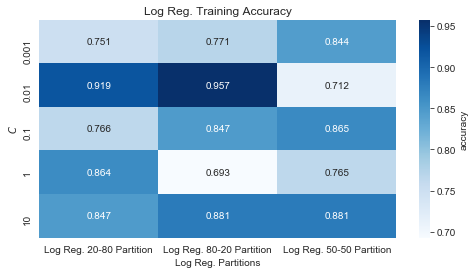

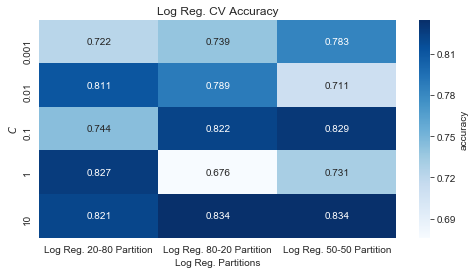

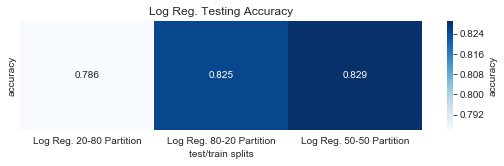

In [21]:
c_list = [0.001, 0.01, 0.1, 1, 10]
partition_names = ["Log Reg. 20-80 Partition", "Log Reg. 80-20 Partition", "Log Reg. 50-50 Partition"]

lr_overall_train_acc = np.array([lr_avg_train_20_80, lr_avg_train_80_20, lr_avg_train_50_50])
lr_overall_train_acc = lr_overall_train_acc.reshape(5, 3)

lr_overall_cv_acc = np.array([lr_avg_cv_20_80, lr_avg_cv_80_20, lr_avg_cv_50_50])
lr_overall_cv_acc = lr_overall_cv_acc.reshape(5, 3)

lr_overall_test_acc = np.array([lr_avg_test_20_80, lr_avg_test_80_20, lr_avg_test_50_50]).reshape(1,3)

heatmap_Log(lr_overall_train_acc, "Log Reg. Training Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_cv_acc, "Log Reg. CV Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_test_acc, "Log Reg. Testing Accuracy", None, partition_names)

## Decision Tree

In [22]:
# Training errors
dt_training_errors_20_80 = []
dt_training_errors_80_20 = []
dt_training_errors_50_50 = []

dt_cv_errors_20_80 = []
dt_cv_errors_80_20 = []
dt_cv_errors_50_50 = []

dt_testing_errors_20_80 = []
dt_testing_errors_80_20 = []
dt_testing_errors_50_50 = []

dt_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
dt_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(dt_train_partitions):
    for ind in range(3):
        
        dt_estimator = DecisionTreeClassifier(criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        dt_param_list = {'max_depth': D_list}
        tree_grid_search = GridSearchCV(dt_estimator, dt_param_list, cv = 5, return_train_score=True)
        tree_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = tree_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = tree_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(dt_test_partitions[val][ind][0],
                               dt_test_partitions[val][ind][1], tree_grid_search)
        if val == 0:
            dt_training_errors_20_80.append(train_errors)
            dt_cv_errors_20_80.append(cross_val_errors)
            dt_testing_errors_20_80.append(test_errors)
        elif val == 1:
            dt_training_errors_80_20.append(train_errors)
            dt_cv_errors_80_20.append(cross_val_errors)
            dt_testing_errors_80_20.append(test_errors)
        elif val == 2:
            dt_training_errors_50_50.append(train_errors)
            dt_cv_errors_50_50.append(cross_val_errors)
            dt_testing_errors_50_50.append(test_errors)

In [23]:
# Show the accuracy of the 20-80 partition
print(dt_training_errors_20_80[0])
print(dt_training_errors_20_80[1])
print(dt_training_errors_20_80[2])

dt_avg_train_20_80 = np.mean(dt_training_errors_20_80, axis=0)
dt_avg_train_80_20 = np.mean(dt_training_errors_80_20, axis=0)
dt_avg_train_50_50 = np.mean(dt_training_errors_50_50, axis=0)

dt_avg_cv_20_80 = np.mean(dt_cv_errors_20_80, axis=0)
dt_avg_cv_80_20 = np.mean(dt_cv_errors_80_20, axis=0)
dt_avg_cv_50_50 = np.mean(dt_cv_errors_50_50, axis=0)

dt_avg_test_20_80 = np.mean(dt_testing_errors_20_80, axis=0)
dt_avg_test_80_20 = np.mean(dt_testing_errors_80_20, axis=0)
dt_avg_test_50_50 = np.mean(dt_testing_errors_50_50, axis=0)

[[0.81666667]
 [0.86666667]
 [0.95833333]
 [0.99166667]
 [1.        ]]
[[0.82916667]
 [0.87083333]
 [0.95416667]
 [0.97916667]
 [0.99583333]]
[[0.8375    ]
 [0.85416667]
 [0.95      ]
 [0.99583333]
 [1.        ]]


In [24]:
def heatmap_DT(acc_arr, title, d_list, split):
    if not d_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=d_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'DT Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

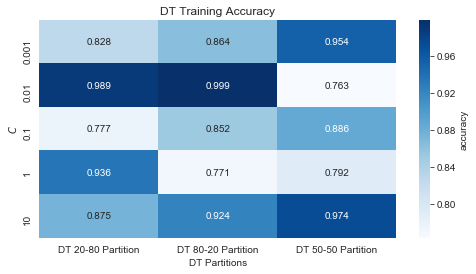

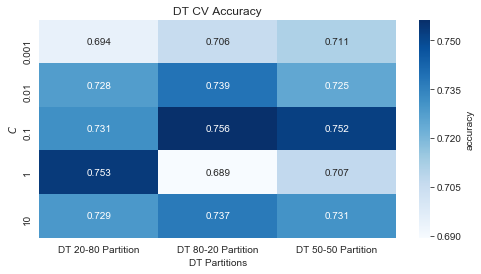

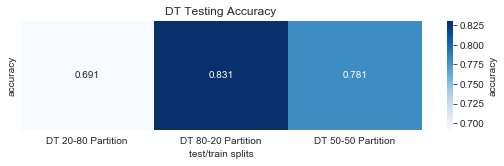

In [25]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["DT 20-80 Partition", "DT 80-20 Partition", "DT 50-50 Partition"]

dt_overall_train_acc = np.array([dt_avg_train_20_80, dt_avg_train_80_20, dt_avg_train_50_50])
dt_overall_train_acc = dt_overall_train_acc.reshape(5, 3)

dt_overall_cv_acc = np.array([dt_avg_cv_20_80, dt_avg_cv_80_20, dt_avg_cv_50_50])
dt_overall_cv_acc = dt_overall_cv_acc.reshape(5, 3)

dt_overall_test_acc = np.array([dt_avg_test_20_80, dt_avg_test_80_20, dt_avg_test_50_50]).reshape(1,3)

heatmap_DT(dt_overall_train_acc, "DT Training Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_cv_acc, "DT CV Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_test_acc, "DT Testing Accuracy", None, partition_names)

## Random Forest

In [26]:
# Training errors
rf_training_errors_20_80 = []
rf_training_errors_80_20 = []
rf_training_errors_50_50 = []

rf_cv_errors_20_80 = []
rf_cv_errors_80_20 = []
rf_cv_errors_50_50 = []

rf_testing_errors_20_80 = []
rf_testing_errors_80_20 = []
rf_testing_errors_50_50 = []

rf_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
rf_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(rf_train_partitions):
    for ind in range(3):
        
        rf_estimator = RandomForestClassifier(n_estimators = 300, criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        rf_param_list = {'max_depth': D_list}
        rf_grid_search = GridSearchCV(rf_estimator, rf_param_list, cv = 5, return_train_score=True)
        rf_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = rf_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = rf_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(rf_test_partitions[val][ind][0],
                               rf_test_partitions[val][ind][1], rf_grid_search)
        if val == 0:
            rf_training_errors_20_80.append(train_errors)
            rf_cv_errors_20_80.append(cross_val_errors)
            rf_testing_errors_20_80.append(test_errors)
        elif val == 1:
            rf_training_errors_80_20.append(train_errors)
            rf_cv_errors_80_20.append(cross_val_errors)
            rf_testing_errors_80_20.append(test_errors)
        elif val == 2:
            rf_training_errors_50_50.append(train_errors)
            rf_cv_errors_50_50.append(cross_val_errors)
            rf_testing_errors_50_50.append(test_errors)

In [27]:
# Show the accuracy of the 20-80 partition
print(rf_training_errors_20_80[0])
print(rf_training_errors_20_80[1])
print(rf_training_errors_20_80[2])

rf_avg_train_20_80 = np.mean(rf_training_errors_20_80, axis=0)
rf_avg_train_80_20 = np.mean(rf_training_errors_80_20, axis=0)
rf_avg_train_50_50 = np.mean(rf_training_errors_50_50, axis=0)

rf_avg_cv_20_80 = np.mean(rf_cv_errors_20_80, axis=0)
rf_avg_cv_80_20 = np.mean(rf_cv_errors_80_20, axis=0)
rf_avg_cv_50_50 = np.mean(rf_cv_errors_50_50, axis=0)

rf_avg_test_20_80 = np.mean(rf_testing_errors_20_80, axis=0)
rf_avg_test_80_20 = np.mean(rf_testing_errors_80_20, axis=0)
rf_avg_test_50_50 = np.mean(rf_testing_errors_50_50, axis=0)

[[0.9       ]
 [0.95833333]
 [0.97916667]
 [0.99166667]
 [1.        ]]
[[0.875     ]
 [0.91666667]
 [0.95      ]
 [0.99166667]
 [1.        ]]
[[0.8625]
 [0.9625]
 [1.    ]
 [1.    ]
 [1.    ]]


In [28]:
def heatmap_RF(acc_arr, title, rf_list, split):
    if not rf_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'RF Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


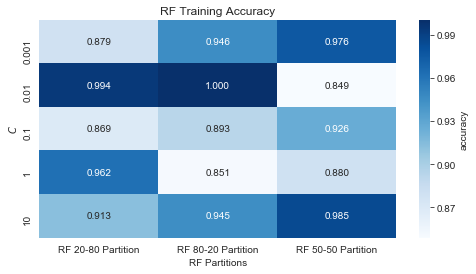

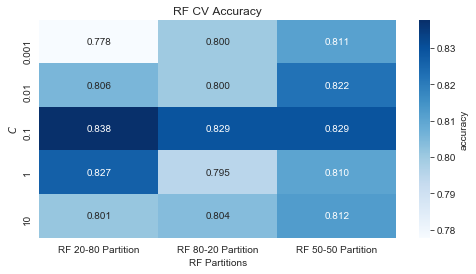

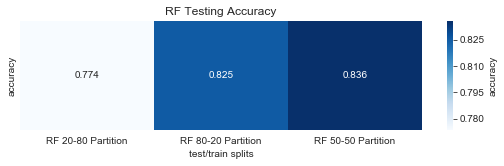

In [29]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["RF 20-80 Partition", "RF 80-20 Partition", "RF 50-50 Partition"]

rf_overall_train_acc = np.array([rf_avg_train_20_80, rf_avg_train_80_20, rf_avg_train_50_50])
rf_overall_train_acc = rf_overall_train_acc.reshape(5, 3)

rf_overall_cv_acc = np.array([rf_avg_cv_20_80, rf_avg_cv_80_20, rf_avg_cv_50_50])
rf_overall_cv_acc = rf_overall_cv_acc.reshape(5, 3)

rf_overall_test_acc = np.array([rf_avg_test_20_80, rf_avg_test_80_20, rf_avg_test_50_50]).reshape(1,3)

heatmap_RF(rf_overall_train_acc, "RF Training Accuracy", c_list, partition_names)
heatmap_RF(rf_overall_cv_acc, "RF CV Accuracy", c_list, partition_names)
heatmap_RF(rf_overall_test_acc, "RF Testing Accuracy", None, partition_names)

# Look at the test results for all 5 Classifiers

In [30]:
print("Support Vector Machine Test Accuracy: ", svc_overall_test_acc)
print("K-Nearest Neighbors Test Accuracy: ", knn_overall_test_acc)
print("Logistic Regression Test Accuracy: ", lr_overall_test_acc)
print("Decision Tree Test Accuracy: ", dt_overall_test_acc)
print("Random forest Test Accuracy: ", rf_overall_test_acc)

Support Vector Machine Test Accuracy:  [[0.78052126 0.82513661 0.82017544]]
K-Nearest Neighbors Test Accuracy:  [[0.5994513  0.66666667 0.59868421]]
Logistic Regression Test Accuracy:  [[0.78600823 0.82513661 0.82894737]]
Decision Tree Test Accuracy:  [[0.69135802 0.83060109 0.78070175]]
Random forest Test Accuracy:  [[0.77366255 0.82513661 0.83552632]]


In [31]:
def heatmap_overall(acc_arr, title, rf_list, split):

    plt.figure(figsize = (16,8))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Overall Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

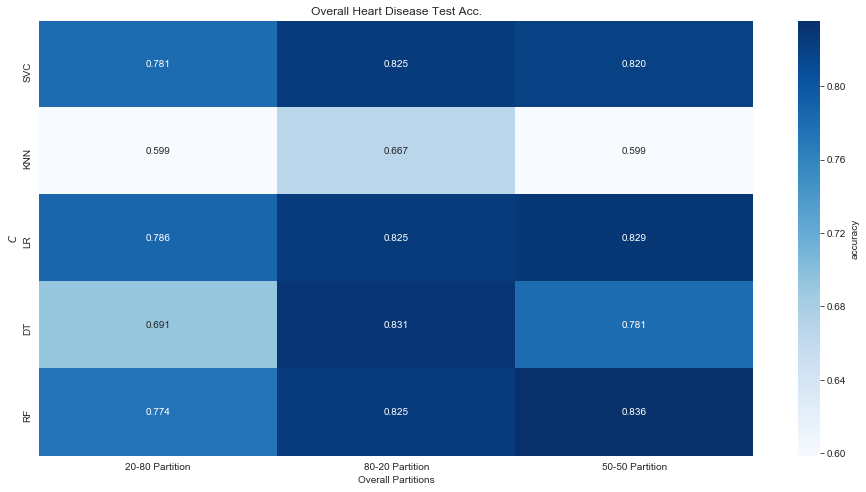

In [32]:
original_wc_results = np.array([svc_overall_test_acc, knn_overall_test_acc, 
                                lr_overall_test_acc, dt_overall_test_acc,
                                rf_overall_test_acc])
original_wc_results = original_wc_results.reshape(5, 3)
partition_names = ["20-80 Partition", "80-20 Partition", "50-50 Partition"]
y_axis_labels = ['SVC', 'KNN', 'LR', 'DT', 'RF']

heatmap_overall(original_wc_results, "Overall Heart Disease Test Acc.", y_axis_labels, partition_names)